### Table of Contents

1. [Loading all Required Libraries](#1)
2. [Load Data](#2)
3. [EDA (Exploratory Data Analysis)](#3)
   - 3.1 [Handling Missing Values](#3.1)
   - 3.2 [Correlation between Features](#3.2)
   - 3.3 [Outliers](#3.3)
   - 3.4 [Skewness and Kurtosis](#3.4)
4. [Data Preprocessing](#4)
   - 4.1 [Handling Imbalanced Data](#4.1)
5. [Model Building and Evaluation](#5)
   - 5.1 [Logistic Regression](#5.1)
     - 5.1.1 [Train the Model without Handling the Imbalanced Class Distribution](#5.1.1)
     - 5.1.2 [Imbalanced Data Handling Techniques](#5.1.2)
       - a) [SMOTE](#a)
       - b) [Near Miss](#b)
       - c) [Random Under Sample](#c)
   - 5.2 [XGBoost Classifier](#5.2)
6. [Using PyCaret To Detect Credit Card Fraud](#6)

### About the Dataset

 - The datasets contains transactions made by credit cards in September 2013 by european cardholders.
 - This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions.
 - The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
 - It contains only numerical input variables which are the result of a PCA transformation.
 - Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data.
 - Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'.
 - Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.
 - The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning.
 - Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

# 1. Loading all Required Libraries

In [57]:
# data information and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")
sns.set()
sns.set_style("darkgrid")

# normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


# data balancing
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


# split data
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report, roc_curve, roc_auc_score, auc, precision_recall_curve, precision_score, recall_score



# 2. Load Data 

In [58]:
train = pd.read_csv("creditcard.csv")

In [59]:
display(train.head())
display(train.tail())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.00,-11.88,10.07,-9.83,-2.07,-5.36,-2.61,-4.92,7.31,1.91,...,0.21,0.11,1.01,-0.51,1.44,0.25,0.94,0.82,0.77,0
284803,172787.00,-0.73,-0.06,2.04,-0.74,0.87,1.06,0.02,0.29,0.58,...,0.21,0.92,0.01,-1.02,-0.61,-0.40,0.07,-0.05,24.79,0
284804,172788.00,1.92,-0.30,-3.25,-0.56,2.63,3.03,-0.30,0.71,0.43,...,0.23,0.58,-0.04,0.64,0.27,-0.09,0.00,-0.03,67.88,0
284805,172788.00,-0.24,0.53,0.70,0.69,-0.38,0.62,-0.69,0.68,0.39,...,0.27,0.80,-0.16,0.12,-0.57,0.55,0.11,0.10,10.00,0
284806,172792.00,-0.53,-0.19,0.70,-0.51,-0.01,-0.65,1.58,-0.41,0.49,...,0.26,0.64,0.38,0.01,-0.47,-0.82,-0.00,0.01,217.00,0


In [60]:
train.shape

(284807, 31)

In [61]:
print(train.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# 3. EDA(Exploratory Data Analysis)

      Checking if data is imbalance

In [63]:
train["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

- Data is highly imbalanced

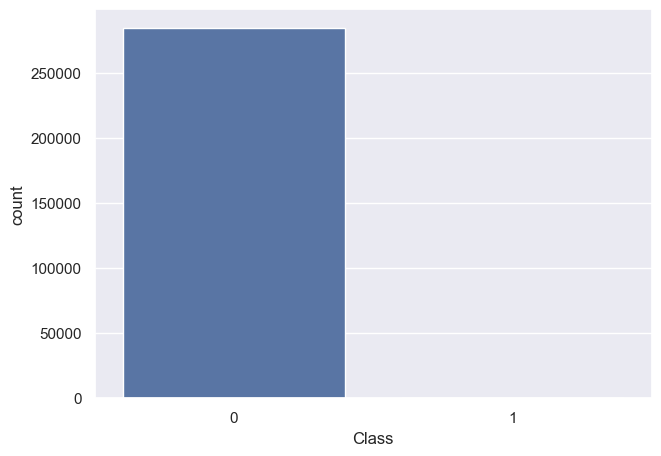

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming "Class" is the column you want to count in your DataFrame
sns.countplot(x="Class", data=train)
plt.show()  # Display the plot if needed

# sns.countplot("Class", data=train)

- As you can see, the non-fraud transactions far outweigh the fraud transactions. If we train a binary classification model without fixing this problem, the model will be completely biased. It also impacts the correlations between features 

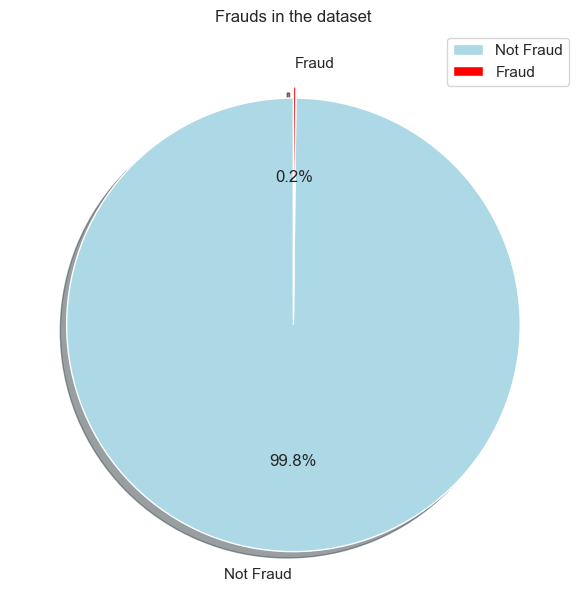

In [65]:
sns.set(style="whitegrid")
labels = ['Not Fraud', 'Fraud']
sizes = train['Class'].value_counts(sort = True)

colors = ["lightblue","red"]
explode = (0.05,0) 
 
plt.figure(figsize=(7,7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90,)

plt.title('Frauds in the dataset')
plt.legend()
plt.show()

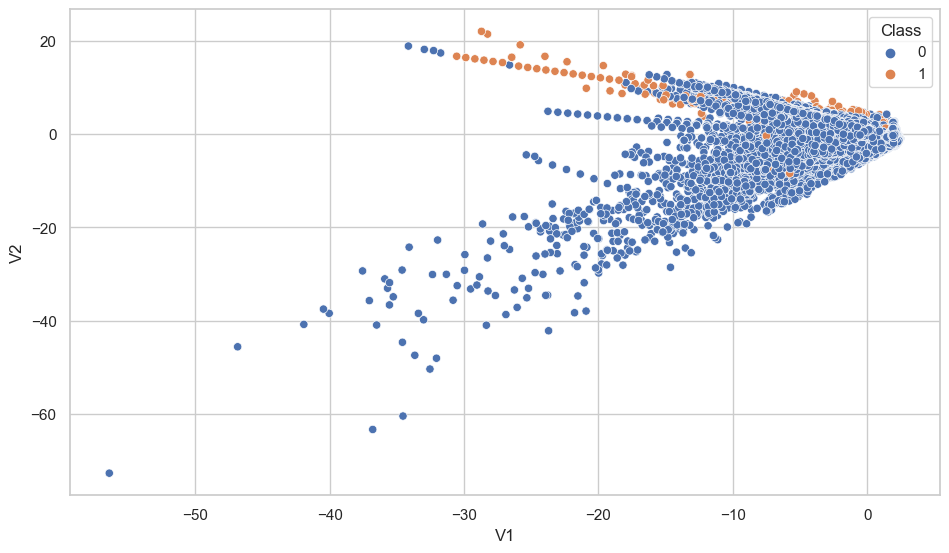

In [66]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="V1", y="V2", hue="Class", data=train);

<Figure size 1000x600 with 0 Axes>

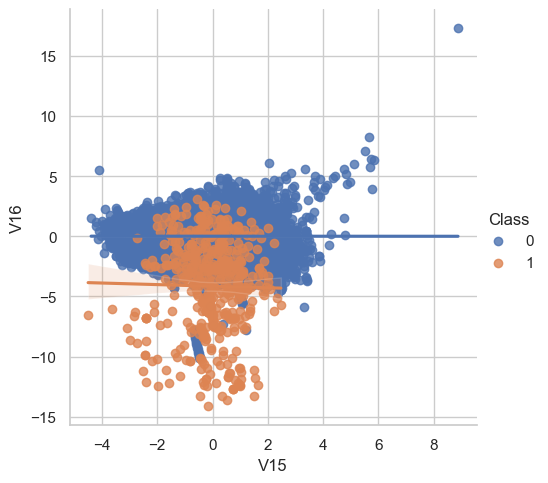

In [67]:
plt.figure(figsize=(10, 6))
sns.lmplot(x="V15", y="V16", hue='Class', data=train, fit_reg=True);

#### 3.1 Handling Missing Values

In [68]:
train.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [69]:
train.isnull().sum().sum()

0

In [70]:
train.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


#### 3.2 Correlation between features

In [71]:
train.corr()['Class'].sort_values(ascending=False)

Class     1.00
V11       0.15
V4        0.13
V2        0.09
V21       0.04
V19       0.03
V20       0.02
V8        0.02
V27       0.02
V28       0.01
Amount    0.01
V26       0.00
V25       0.00
V22       0.00
V23      -0.00
V15      -0.00
V13      -0.00
V24      -0.01
Time     -0.01
V6       -0.04
V5       -0.09
V9       -0.10
V1       -0.10
V18      -0.11
V7       -0.19
V3       -0.19
V16      -0.20
V10      -0.22
V12      -0.26
V14      -0.30
V17      -0.33
Name: Class, dtype: float64

The result of this code will be a series of correlation values with the column names as indices, sorted in descending order of correlation. This quickly identifies which columns have the strongest positive or negative correlations with the "Class" column, which can be valuable information when working with classification tasks to understand which features are more important or relevant for predicting the target variable.

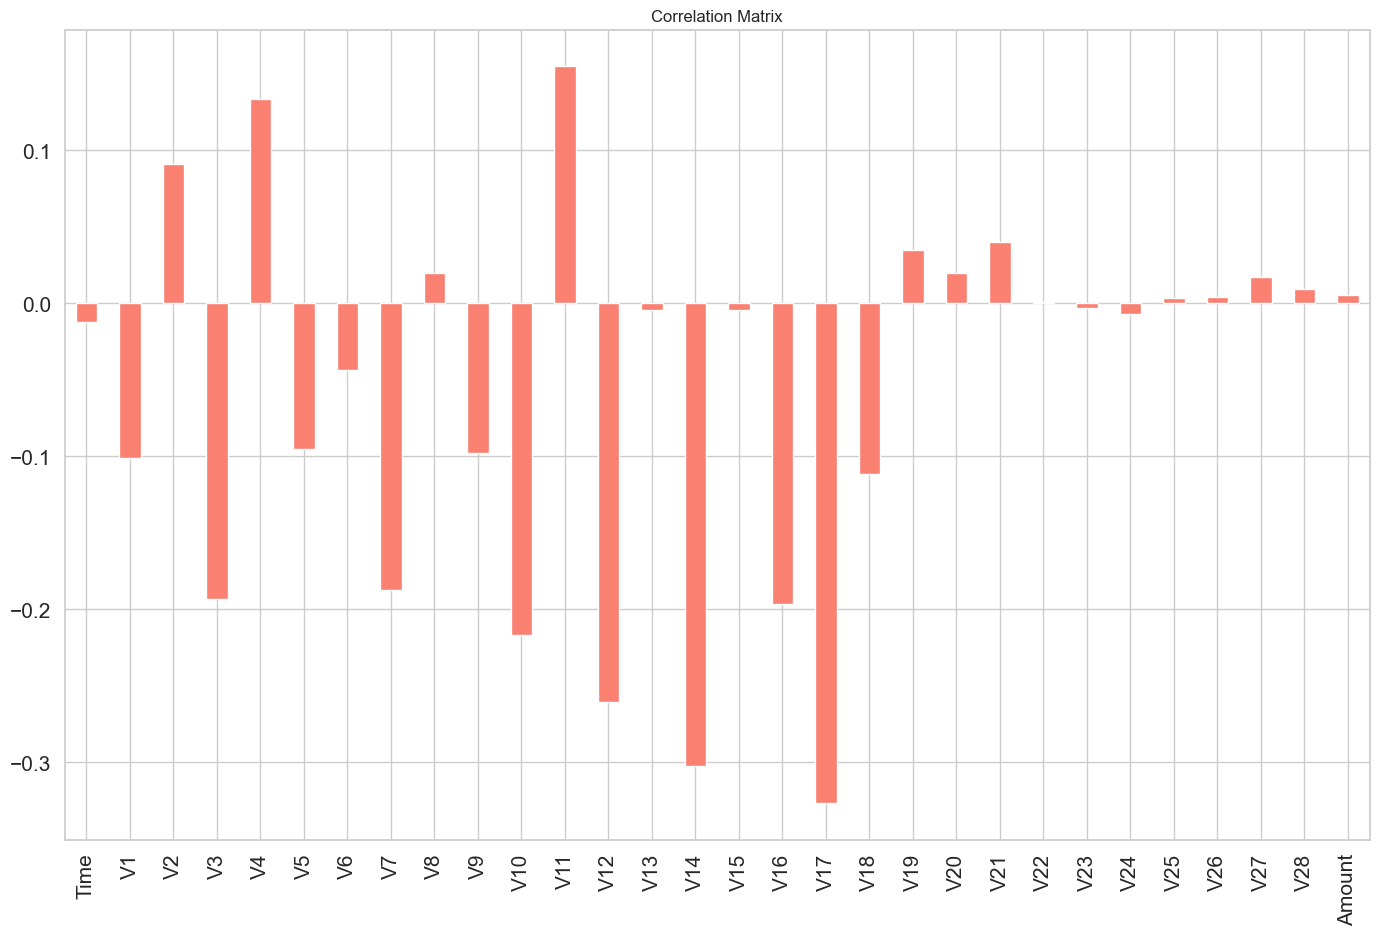

In [72]:
a = train.drop('Class', axis=1)
a.corrwith(train['Class']).plot(kind='bar', figsize=(15,10), color=['salmon'])
plt.title("Correlation Matrix")
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

- from above graph observe that correlation is less for features : **V13, V15, V22, V23, V24, V25, V26, V27, V28, Amount & Time**

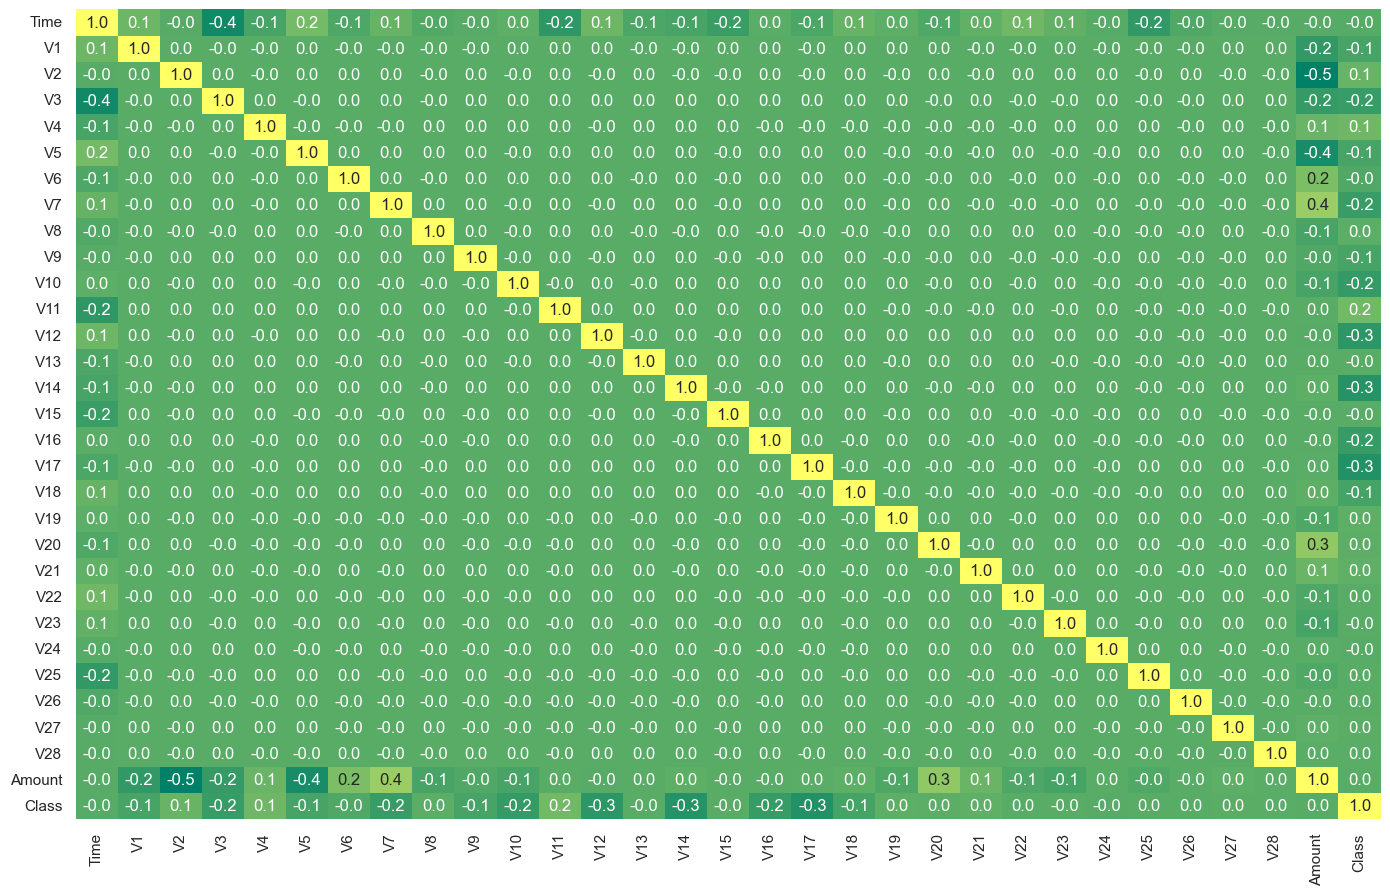

In [73]:
plt.figure(figsize=(15,10))
sns.heatmap(train.corr(), annot=True, cbar=False, fmt='.1f', cmap='summer')
plt.show()

#### 3.3 Outliers

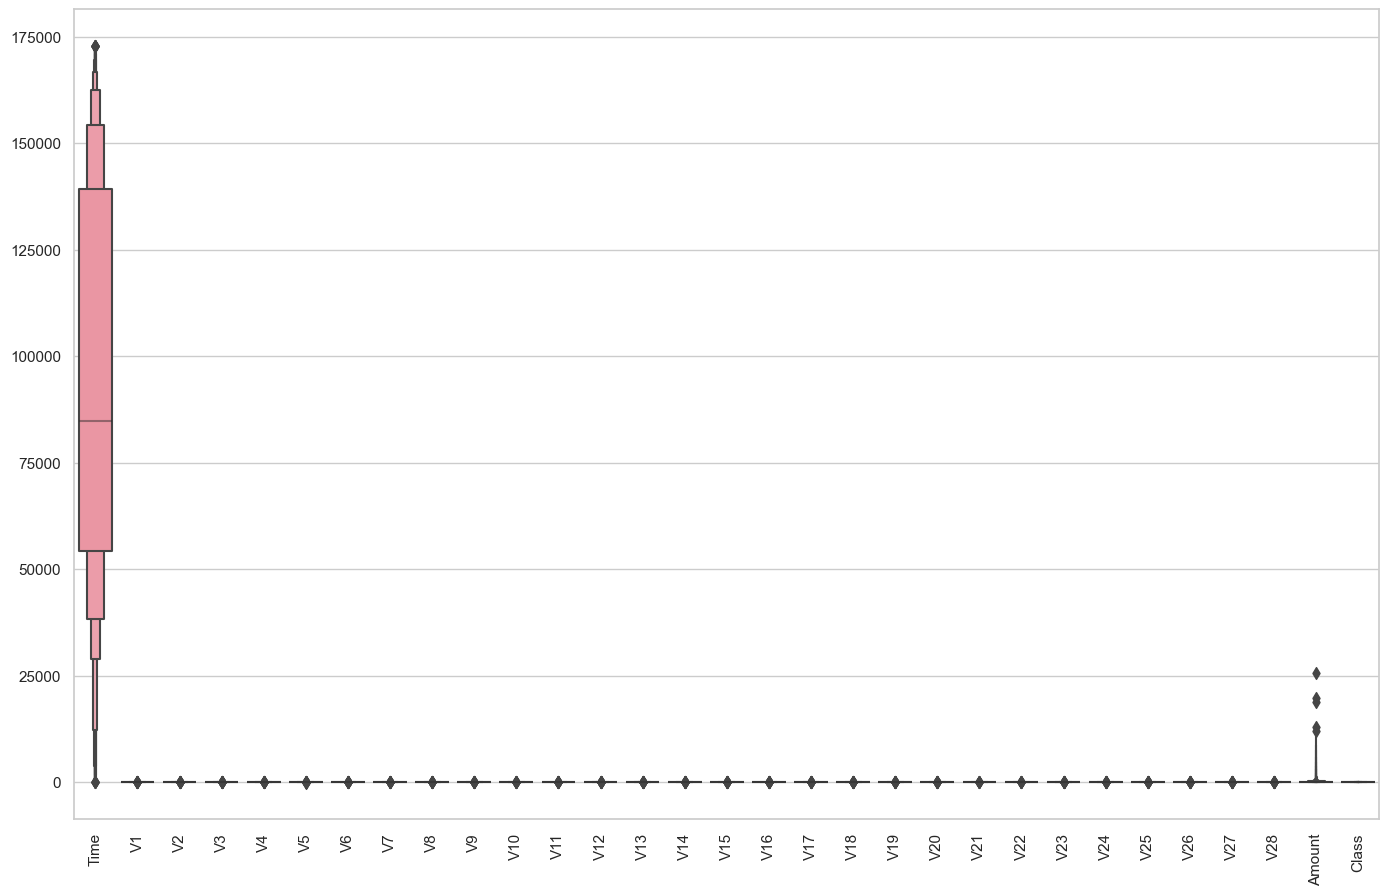

In [74]:
plt.figure(figsize=(15,10))
sns.boxenplot(data=train)
plt.xticks(rotation=90)
plt.show()

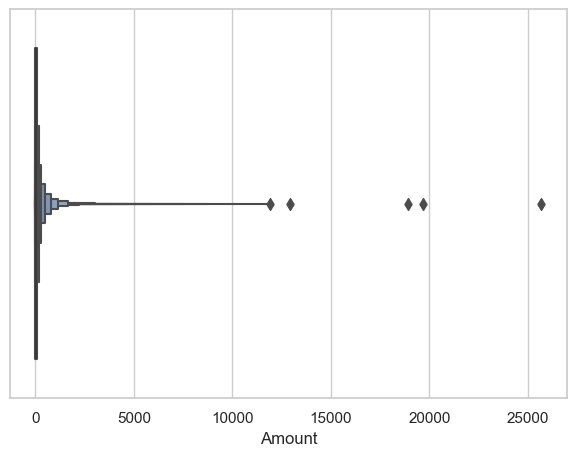

In [75]:
plt.tight_layout()
sns.boxenplot(x=train['Amount'], data=train)
plt.show()

#### 3.4 Skewness and Kurtosis

In [76]:
display(train.skew())

Time     -0.04
V1       -3.28
V2       -4.62
V3       -2.24
V4        0.68
V5       -2.43
V6        1.83
V7        2.55
V8       -8.52
V9        0.55
V10       1.19
V11       0.36
V12      -2.28
V13       0.07
V14      -2.00
V15      -0.31
V16      -1.10
V17      -3.84
V18      -0.26
V19       0.11
V20      -2.04
V21       3.59
V22      -0.21
V23      -5.88
V24      -0.55
V25      -0.42
V26       0.58
V27      -1.17
V28      11.19
Amount   16.98
Class    24.00
dtype: float64

Interpretation:

The code calculates and displays the skewness of each column in the `train` DataFrame. Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable.  

Here's how to interpret these values:

1. *Time*: A skewness value of -0.035568 indicates a slight negative skew. This means that the distribution is slightly skewed to the left.

2. *V1* through *V28*: These columns have varying skewness values, both positive and negative. Positive skewness (greater than 0) indicates that the distribution is right-skewed, while negative skewness (less than 0) indicates that the distribution is left-skewed. The magnitude of the skewness values indicates the degree of skewness.

3. *Amount*: A skewness value of 16.977724 indicates a very high positive skew. This means that the distribution of the "Amount" column is heavily right-skewed.

4. *Class*: A skewness value of 23.997579 indicates an extremely high positive skew. This suggests that the distribution of the "Class" column is heavily right-skewed. However, this column typically contains binary data (0 or 1), so the skewness value may not be as informative for this particular column.

In summary, the skewness values provide information about the shape of the distributions in each column. Negative skewness indicates a left-skewed distribution, positive skewness indicates a right-skewed distribution, and the magnitude of the skewness value indicates the degree of skewness. In practice, understanding the skewness of data can help you decide whether certain transformations or adjustments are needed to make the data more suitable for analysis or modeling, especially if you are working with algorithms or statistical methods that assume normally distributed data.

Text(0.5, 1.0, 'Skew:16.977724453761024')

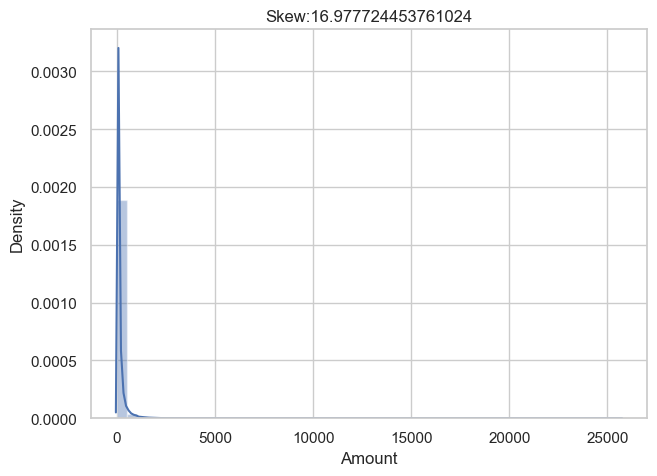

In [77]:
sns.distplot(train['Amount'])
skew_Class = train['Amount'].skew()
plt.title('Skew:'+str(skew_Class))

Text(0.5, 1.0, 'skew:11.19209119221281')

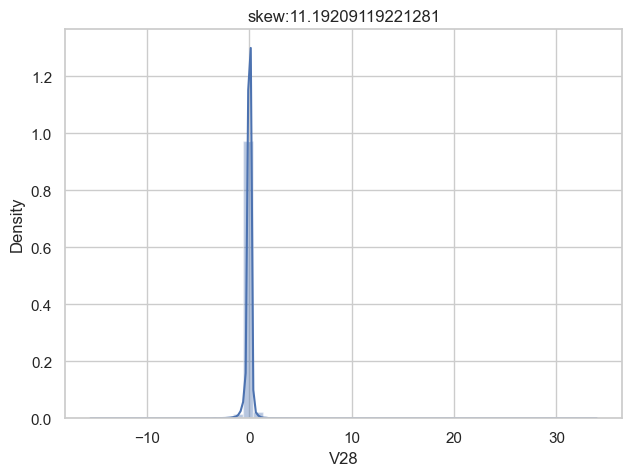

In [78]:
sns.distplot(train['V28'])
skew_V28 = train['V28'].skew()
plt.title('skew:'+str(skew_V28))

# 4. Data Preprocessing

In [79]:
sc = StandardScaler()

# normalise the amount column
train['normAmount'] = sc.fit_transform(np.array(train['Amount']).reshape(-1, 1))
  
# drop Time and Amount columns as they are not relevant for prediction purpose 
train = train.drop(['Time', 'Amount'], axis = 1)

In [80]:
train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,0.09,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,0,0.24
1,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,-0.17,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,0,-0.34
2,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,0.21,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,0,1.16
3,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,-0.05,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,0,0.14
4,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,0.75,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,0,-0.07


In [81]:
train.shape

(284807, 30)

#### 4.1 Handling Imbalanced Data 


- Generally happens when observations in one of the **class are much higher or lower than the other classes**. As Machine Learning algorithms tend to increase accuracy by reducing the error, they do not consider the class distribution. This problem is prevalent in examples such as **Fraud Detection, Anomaly Detection, Facial recognition** etc.

- Standard ML techniques such as **Decision Tree and Logistic Regression** have a **bias towards the majority class**, and they tend to **ignore the minority class**. They tend only to predict the majority class, hence, having major misclassification of the minority class in comparison with the majority class. In more technical words, if we have imbalanced data distribution in our dataset then our model becomes more prone to the case when minority class has negligible or very lesser recall.

 **Imbalanced Data Handling Techniques:** There are mainly 2 algorithms that are widely used for handling imbalanced class distribution.

 - 1) SMOTE

 - 2) Near Miss Algorithm
 
#### 1. SMOTE (Synthetic Minority Oversampling Technique) – Oversampling:

 - SMOTE (synthetic minority oversampling technique) is one of the most commonly used oversampling methods to solve the imbalance problem. It aims to balance class distribution by randomly increasing minority class examples by replicating them. SMOTE synthesises new minority instances between existing minority instances. It generates the virtual training records by linear interpolation for the minority class. These synthetic training records are generated by randomly selecting one or more of the k-nearest neighbors for each example in the minority class. After the oversampling process, the data is reconstructed and several classification models can be applied for the processed data.
 
#### 2. NearMiss Algorithm – Undersampling

 - NearMiss is an under-sampling technique. It aims to balance class distribution by randomly eliminating majority class examples. When instances of two different classes are very close to each other, we remove the instances of the majority class to increase the spaces between the two classes. This helps in the classification process. To prevent problem of information loss in most under-sampling techniques, near-neighbor methods are widely used.
 
#### STEPS:

- **Step 1:** The method first finds the distances between all instances of the majority class and the instances of the minority class. Here, majority class is to be under-sampled.

- **Step 2:** Then, n instances of the majority class that have the smallest distances to those in the minority class are selected.

- **Step 3:** If there are k instances in the minority class, the nearest method will result in k*n instances of the majority class.

#### For finding n closest instances in the majority class, there are several variations of applying NearMiss Algorithm :

- **NearMiss – Version 1 :** It selects samples of the majority class for which average distances to the k closest instances of the minority class is smallest.

- **NearMiss – Version 2 :** It selects samples of the majority class for which average distances to the k farthest instances of the minority class is smallest.

- **NearMiss – Version 3 :** It works in 2 steps. Firstly, for each minority class instance, their M nearest-neighbors will be stored. Then finally, the majority class instances are selected for which the average distance to the N nearest-neighbors is the largest.

# 5. Model Building and Evaluation

In [82]:
# Independant variable
X = train.drop('Class', axis=1)

# Dependant variable
y = train['Class']

In [83]:
# split into 70:30 ration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [84]:
# describes info about train and test set
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (199364, 29)
Number transactions y_train dataset:  (199364,)
Number transactions X_test dataset:  (85443, 29)
Number transactions y_test dataset:  (85443,)


#### 5.1 Logistic Regression

#### 5.1.1 Train the model without handling the imbalanced class distribution

In [85]:
# logistic regression object
lr = LogisticRegression()
  
# train the model on train set
lr.fit(X_train, y_train.ravel())

LogisticRegression()

Ravel

- The numpy module of Python provides a function called **numpy.ravel**, which is used to **change a 2-dimensional array or a multi-dimensional array into a contiguous flattened array**. 

The returned array has the same data type as the source array or input array. If the input array is a masked array, the returned array will also be a masked array.

In [86]:
predictions = lr.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print('accuracy of base model :', accuracy)
print("\nBase Model: Train Score {:.2f} & Test Score {:.2f} \n".format(lr.score(X_train, y_train), lr.score(X_test, y_test)))

# print confusion matrix
print('Confusion Matrix :\n\n', confusion_matrix(y_test, predictions))
  
# print classification report
print('\n\nClassification Report :\n', classification_report(y_test, predictions))

accuracy of base model : 0.999204147794436

Base Model: Train Score 1.00 & Test Score 1.00 

Confusion Matrix :

 [[85284    12]
 [   56    91]]


Classification Report :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.88      0.62      0.73       147

    accuracy                           1.00     85443
   macro avg       0.94      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443



Interpretation:


1. The accuracy comes out to be 100% 

2. The recall of the minority class in very less. It proves that the model is **more biased towards majority class**. So, it proves that this is not the best model.

Now, we will apply different **imbalanced data handling techniques** and see their accuracy and recall results

#### 5.1.2 imbalanced data handling techniques

a) SMOTE

In [87]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 345
Before OverSampling, counts of label '0': 199019 



In [88]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

In [89]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, the shape of train_X: (398038, 29)
After OverSampling, the shape of train_y: (398038,) 

After OverSampling, counts of label '1': 199019
After OverSampling, counts of label '0': 199019


SMOTE Algorithm has **oversampled the minority instances** and made it **equal to majority class**.

Both categories have equal amount of records. More specifically, the minority class has been increased to the total number of majority class.

In [90]:
lr1 = LogisticRegression()
lr1.fit(X_train_res, y_train_res.ravel())
predictions = lr1.predict(X_test)

In [91]:
accuracy = accuracy_score(y_test, predictions)
print('accuracy of base model :', accuracy)
print("\nBase Model: Train Score {:.2f} & Test Score {:.2f} \n".format(lr.score(X_train_res, y_train_res), lr.score(X_test, y_test)))

# print confusion matrix
print('Confusion Matrix :\n\n', confusion_matrix(y_test, predictions))

# print classification report
print(classification_report(y_test, predictions))

accuracy of base model : 0.9752583593740857

Base Model: Train Score 0.81 & Test Score 1.00 

Confusion Matrix :

 [[83194  2102]
 [   12   135]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85296
           1       0.06      0.92      0.11       147

    accuracy                           0.98     85443
   macro avg       0.53      0.95      0.55     85443
weighted avg       1.00      0.98      0.99     85443



#### We have reduced the accuracy to **98%** as compared to previous model but the **recall** value of **minority class** has also improved to **92 %**. This is a good model compared to the previous one. 

In [92]:
class_names = ['not_fraud', 'fraud']
matrix = confusion_matrix(y_test, predictions)
print(matrix)

# Create pandas dataframe
df = pd.DataFrame(matrix, index=class_names, columns=class_names)

[[83194  2102]
 [   12   135]]


Interpretation:

The code calculates and displays a confusion matrix for a binary classification problem. In this case, there are two classes: "not_fraud" and "fraud." The confusion matrix is a table that is often used to evaluate the performance of a classification algorithm. The table has four important values:

- **True Positives (TP)**: The number of instances that were correctly predicted as "fraud."
- **True Negatives (TN)**: The number of instances that were correctly predicted as "not_fraud."
- **False Positives (FP)**: The number of instances that were incorrectly predicted as "fraud" (they are actually "not_fraud").
- **False Negatives (FN)**: The number of instances that were incorrectly predicted as "not_fraud" (they are actually "fraud").

The confusion matrix is typically organized as follows:

```
[[TN  FP]
 [FN  TP]]
```

The confusion matrix values are as follows:

- True Negatives (TN): 83,194
- False Positives (FP): 2,102
- False Negatives (FN): 12
- True Positives (TP): 135

So, in the context of your binary classification problem:

- 83,194 instances were correctly predicted as "not_fraud."
- 135 instances were correctly predicted as "fraud."
- 2,102 instances were incorrectly predicted as "fraud" when they were actually "not_fraud."
- 12 instances were incorrectly predicted as "not_fraud" when they were actually "fraud."



In [93]:
y_pred_logit_proba = lr1.predict_proba(X_test)[::,1]
fpr_logit, tpr_logit, _ = roc_curve(y_test,  y_pred_logit_proba)
auc_logit = roc_auc_score(y_test, y_pred_logit_proba)
print("AUC Logistic Regression :", auc_logit)

AUC Logistic Regression : 0.984072392322151


Interpretation:

The code calculates the Area Under the Receiver Operating Characteristic (ROC) Curve (AUC) for a logistic regression model. The ROC curve and AUC are commonly used to evaluate the performance of binary classification models. Here's an explanation of the code and its result:

1. `y_pred_logit_proba = lr1.predict_proba(X_test)[::,1]`: This line of code calculates the predicted probabilities of the positive class (in this case, "fraud") for the test data using a logistic regression model (`lr1`). The predicted probabilities for the positive class are extracted from the result and stored in the `y_pred_logit_proba` array.

2. `fpr_logit, tpr_logit, _ = roc_curve(y_test,  y_pred_logit_proba)`: This line of code calculates the False Positive Rate (FPR) and True Positive Rate (TPR) at different probability thresholds for the logistic regression model. The `roc_curve` function takes the true labels (`y_test`) and the predicted probabilities (`y_pred_logit_proba`) as input and returns the FPR and TPR values.

3. `auc_logit = roc_auc_score(y_test, y_pred_logit_proba)`: This line of code calculates the AUC for the ROC curve. The `roc_auc_score` function computes the AUC based on the true labels and predicted probabilities.

4. `print("AUC Logistic Regression :", auc_logit)`: This line of code prints the AUC value for the logistic regression model.

The result, "AUC Logistic Regression : 0.984072392322151," indicates that the logistic regression model has a high AUC score of approximately 0.984. A higher AUC value is desirable, as it suggests that the model is better at distinguishing between the two classes (fraud and not fraud). An AUC of 1.0 represents a perfect model, while an AUC of 0.5 represents a model that performs no better than random chance.

In summary, an AUC of 0.984 is a strong indication that the logistic regression model is performing well in terms of its ability to discriminate between the two classes in the binary classification task.

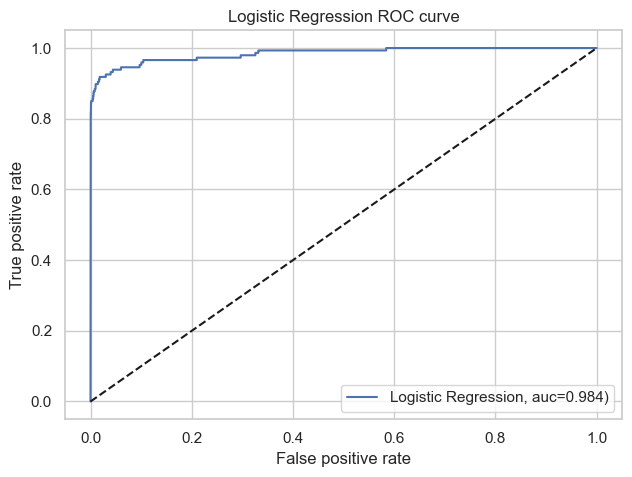

In [94]:
# ROC Curve
plt.plot(fpr_logit,tpr_logit,label="Logistic Regression, auc={:.3f})".format(auc_logit))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic Regression ROC curve')
plt.legend(loc=4)
plt.show()

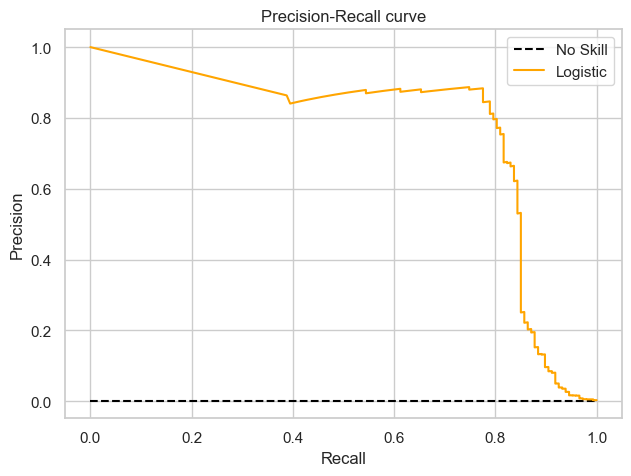

In [95]:
logit_precision, logit_recall, _ = precision_recall_curve(y_test, y_pred_logit_proba)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')
plt.plot(logit_recall, logit_precision, color='orange', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

Interpretation:

The provided code is used to generate a Precision-Recall curve and includes a line to represent the "No Skill" baseline. Here's an explanation of each part of the code and the resulting plot:

1. `logit_precision, logit_recall, _ = precision_recall_curve(y_test, y_pred_logit_proba)`: This line of code calculates the precision and recall values at different probability thresholds for the logistic regression model. The `precision_recall_curve` function takes the true labels `y_test` and the predicted probabilities `y_pred_logit_proba` as input and returns arrays of precision and recall values.

2. `no_skill = len(y_test[y_test == 1]) / len(y_test)`: This line calculates the "No Skill" baseline precision. It counts the number of positive (1) instances in `y_test` and divides it by the total number of instances to calculate the precision that would result from a classifier that always predicts the positive class. This "No Skill" precision serves as a baseline for comparison.

3. `plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')`: This line of code plots a horizontal dashed line to represent the "No Skill" baseline. The `[0, 1]` range on the x-axis represents the entire range of recall values, and `no_skill` is used as the y-coordinate for all points along this line. It is labeled as "No Skill" in the legend.

4. `plt.plot(logit_recall, logit_precision, color='orange', label='Logistic')`: This line of code plots the Precision-Recall curve for the logistic regression model. It uses the calculated `logit_recall` and `logit_precision` arrays. The curve is colored orange, and it is labeled as "Logistic" in the legend.

5. `plt.xlabel('Recall')`: This line sets the x-axis label to "Recall," representing the true positive rate.

6. `plt.ylabel('Precision')`: This line sets the y-axis label to "Precision," representing the proportion of correctly predicted positive instances among all instances predicted as positive.

7. `plt.title('Precision-Recall curve')`: This line sets the title of the plot to "Precision-Recall curve."

8. `plt.legend()`: This line displays the legend on the plot, which helps identify the "No Skill" baseline and the "Logistic" curve.

9. `plt.show()`: Finally, this line displays the plot on the screen.

The resulting plot is a Precision-Recall curve, which is used to assess the trade-off between precision and recall for a binary classification model. The curve shows how precision and recall change at different probability thresholds. The area under the curve (AUC-PR) is a common metric to evaluate the performance of a model. A higher AUC-PR indicates better performance. In this case, the "Logistic" curve represents the performance of the logistic regression model, and the "No Skill" baseline represents the performance of a naive classifier that predicts the positive class with a constant probability equal to the proportion of positive instances in the dataset. The plot helps you understand the model's ability to make accurate positive predictions while minimizing false positives.

b) NearMiss

In [96]:
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0)))
  
# Applying near miss
from imblearn.under_sampling import NearMiss
nr = NearMiss()
  
X_train_miss, y_train_miss = nr.fit_resample(X_train, y_train.ravel())

# X_train_miss, y_train_miss = nr.fit_sample(X_train, y_train.ravel())
  
print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape))
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape))
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1)))
print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0)))

Before Undersampling, counts of label '1': 345
Before Undersampling, counts of label '0': 199019 

After Undersampling, the shape of train_X: (690, 29)
After Undersampling, the shape of train_y: (690,) 

After Undersampling, counts of label '1': 345
After Undersampling, counts of label '0': 345


The NearMiss Algorithm has **undersampled** the **majority instances** and made it **equal to minority class**.

Here, the **majority class** has been **reduced** to the total number of **minority class**, so that both classes will have equal number of records.

In [97]:
# train the model on train set
lr2 = LogisticRegression()
lr2.fit(X_train_miss, y_train_miss.ravel())
predictions = lr2.predict(X_test)

In [98]:
accuracy = accuracy_score(y_test, predictions)
print('accuracy of base model :', accuracy)
print("\nBase Model: Train Score {:.2f} & Test Score {:.2f} \n".format(lr.score(X_train_res, y_train_res), lr.score(X_test, y_test)))

# print confusion matrix
print('Confusion Matrix :\n\n', confusion_matrix(y_test, predictions))

# print classification report
print(classification_report(y_test, predictions))

accuracy of base model : 0.5552707653055253

Base Model: Train Score 0.81 & Test Score 1.00 

Confusion Matrix :

 [[47304 37992]
 [    7   140]]
              precision    recall  f1-score   support

           0       1.00      0.55      0.71     85296
           1       0.00      0.95      0.01       147

    accuracy                           0.56     85443
   macro avg       0.50      0.75      0.36     85443
weighted avg       1.00      0.56      0.71     85443



Interpretation:

This model is better than the first model because it classifies better and also the recall value of minority class is 95 %. But due to undersampling of majority class, its recall has decreased to 56 %.
So in this case, SMOTE is gave a great accuracy and recall, I’ll go ahead and use that model!

c) Random Under Sample

In [99]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler


undersample = RandomUnderSampler(sampling_strategy=0.5)

In [100]:
cols = train.columns.tolist()
cols = [c for c in cols if c not in ["Class"]]
target = "Class"

In [101]:
X = train[cols]
Y = train[target]

# undersample
X_under, Y_under = undersample.fit_resample(X, Y)

In [102]:
test = pd.DataFrame(Y_under, columns = ['Class'])

In [103]:
test.shape

(1476, 1)

Text(0.5, 1.0, 'After')

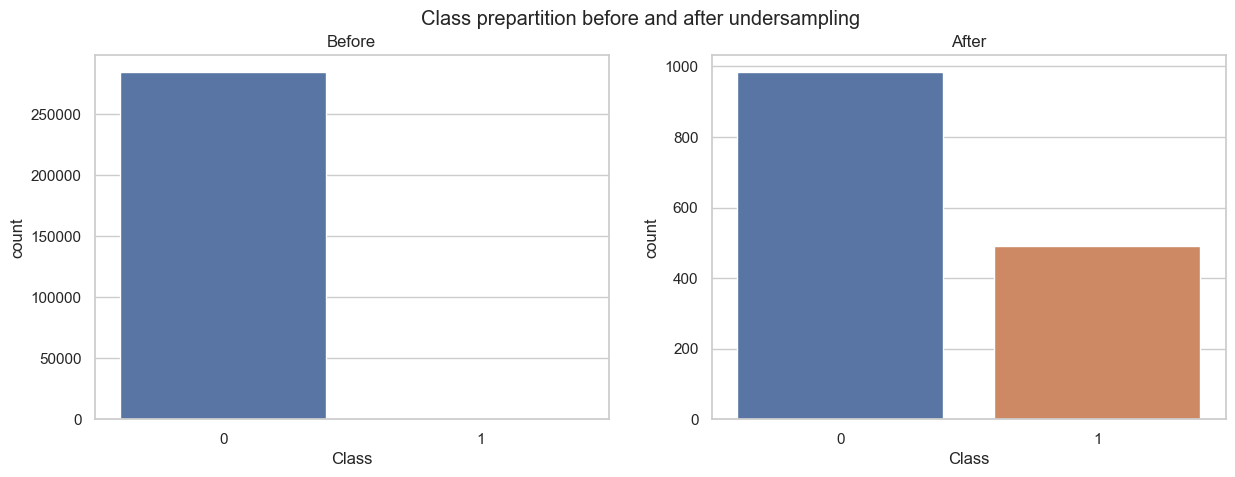

In [104]:
# visualizing undersampling results
fig, axs = plt.subplots(ncols=2, figsize=(13,4.5))
sns.countplot(x="Class", data=train, ax=axs[0])
sns.countplot(x="Class", data=test, ax=axs[1])

fig.suptitle("Class prepartition before and after undersampling")
a1=fig.axes[0]
a1.set_title("Before")
a2=fig.axes[1]
a2.set_title("After")

#### 5.2 XGBoost Classifier

In [105]:
xgb = XGBClassifier(random_state=2)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=2, ...)

In [106]:
y_pred_xgb = xgb.predict(X_test)

In [107]:
print("Accuracy XGB:", accuracy_score(y_test, y_pred_xgb))
print("Precision XGB:", precision_score(y_test, y_pred_xgb))
print("Recall XGB:", recall_score(y_test, y_pred_xgb))
print("F1 Score XGB:", f1_score(y_test, y_pred_xgb))

Accuracy XGB: 0.9995786664794073
Precision XGB: 0.944
Recall XGB: 0.8027210884353742
F1 Score XGB: 0.8676470588235294


Interpretation:

The code trains an XGBoost classifier (XGBClassifier) on the data and evaluates its performance using various classification metrics. Here's an explanation of the metrics and the results you obtained:

1. **Accuracy**: Accuracy is a measure of how many of the predicted labels match the true labels. In this case, the XGBoost model achieved an accuracy of approximately 0.9996, which is very high. It indicates that the majority of predictions made by the model are correct.

2. **Precision**: Precision is the ratio of true positive predictions to the total positive predictions (true positives + false positives). In this case, the XGBoost model achieved a precision of 0.944, which is also high. It suggests that when the model predicts a sample as positive, it is correct about 94.4% of the time.

3. **Recall**: Recall, also known as True Positive Rate or Sensitivity, is the ratio of true positive predictions to the total actual positive instances (true positives + false negatives). The model achieved a recall of approximately 0.8027, which is still decent. This indicates that the model can identify about 80.27% of the actual positive instances.

4. **F1 Score**: The F1 Score is the harmonic mean of precision and recall. It provides a balance between precision and recall. In this case, the XGBoost model achieved an F1 score of approximately 0.8676, which is a good indicator of overall model performance.

In summary, the results suggest that your XGBoost model is performing well in terms of accuracy, precision, recall, and the F1 score. These metrics indicate that the model is making correct predictions with high accuracy and maintaining a good balance between precision and recall. 

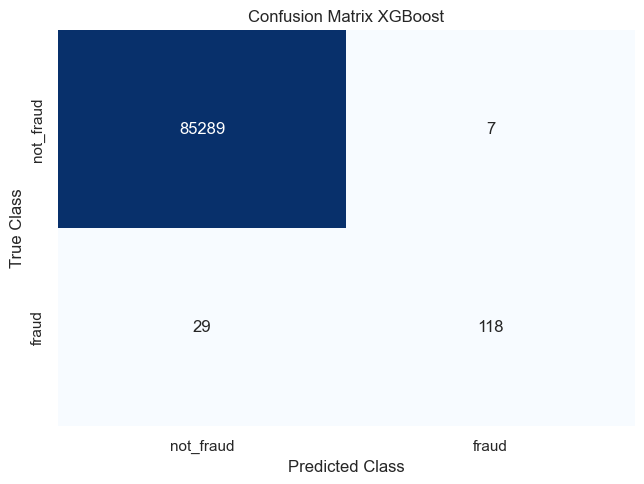

In [108]:
matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_xgb = pd.DataFrame(matrix_xgb, index=['not_fraud', 'fraud'], columns=['not_fraud', 'fraud'])

sns.heatmap(cm_xgb, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix XGBoost"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

Interpretation:

The top-left cell (85289) represents the count of true negatives, which are instances correctly classified as class 0.

The top-right cell (7) represents the count of false positives, which are instances incorrectly classified as class 1 when they are actually class 0.

The bottom-left cell (29) represents the count of false negatives, which are instances incorrectly classified as class 0 when they are actually class 1.

The bottom-right cell (118) represents the count of true positives, which are instances correctly classified as class 1.

In [109]:
y_pred_xgb_proba = xgb.predict_proba(X_test)[::,1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test,  y_pred_xgb_proba)
auc_xgb = roc_auc_score(y_test, y_pred_xgb_proba)
print("AUC XGBoost :", auc_xgb)

AUC XGBoost : 0.968528163469477


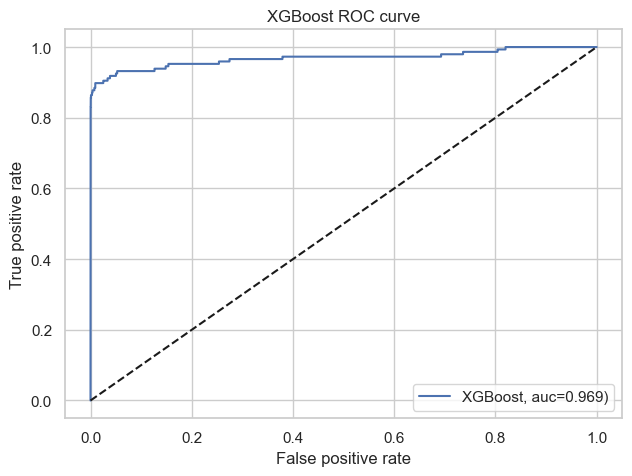

In [110]:
# ROC Curve
plt.plot(fpr_xgb,tpr_xgb,label="XGBoost, auc={:.3f})".format(auc_xgb))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('XGBoost ROC curve')
plt.legend(loc=4)
plt.show()

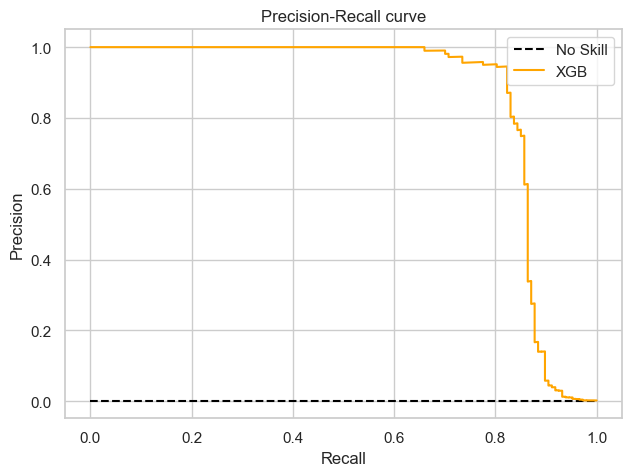

In [111]:
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, y_pred_xgb_proba)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')
plt.plot(xgb_recall, xgb_precision, color='orange', label='XGB')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()